# Detecting Fraudulent Credit Card Transactions

## Introduction

In this project, we will develop classification systems for the detection of fraudulent credit card activity, using a dataset of credit card transactions provided on [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). As most credit card transactions are genuine, this task will require us to work with a highly imbalanced dataset. Thus, to build a powerful classifier that is capable of detecting fraud, we will need to solve the issue of data imbalance, which will be a key consideration throughout this project. 

As we walk through this project, all steps will be thoroughly explained and documented. Looking ahead, we will tackle the data imbalance problem using an upsampling/oversamplling method known as Synthetic Minority Oversampling Technique, or **SMOTE**. We will clean and process our data before feeding it to 2 key models of interest: **Light GBM and XGBoost**. Lastly, we will evaluate our models on a test set of credit card transactions to determine the precision and recall of our classifiers, and we will also assess the performance of an **artificial neural network (ANN)**. Our goal is to build a fraud detection classifier that maximizes F1 score by achieving high precision and recall. 





## Setup
In this section, we will set up our environment by importing libraries, managing packages, and writing utility functions for later use.

### Installing LightGBM 
We will be using Light GBM (LGBM) with GPU in this Google Colab notebook. The version of Light GBM installed by default does not support GPU. To make use of GPU support, we need to uninstall the existing LGBM and reinstall the GPU version.

In [ ]:
! pip uninstall lightgbm

Uninstalling lightgbm-2.2.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/lightgbm-2.2.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/lightgbm/*
Proceed (y/n)? y
  Successfully uninstalled lightgbm-2.2.3


In [ ]:
# After running
! git clone --recursive https://github.com/Microsoft/LightGBM

#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    

### Imports

In [17]:
# Core Libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from scipy import stats

# Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, learning_curve, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Predictive Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Neural Networks
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential

# Visualization Settings
sns.set_theme(style='whitegrid', palette='deep')
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['figure.autolayout'] = True

import warnings
warnings.filterwarnings("ignore")

### Loading the data
The dataset has been provided by ULB Machine Learning on Kaggle. We are importing it from Google Drive storage, but the data can also be accessed from the [Kaggle API](https://www.kaggle.com/mlg-ulb/creditcardfraud). 

In [18]:
# Load data
drive_url = '/content/drive/MyDrive/Colab Notebooks/Projects/fraud/creditcard.csv'
credit_card = pd.read_csv(drive_url)

### Utility Functions

#### Plotting learning curves
Adapted from the [Scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).

In [19]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None,
                        cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
  if axes is None:
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
  
  axes[0].set_title(title)
  if ylim is not None:
    axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
  
  train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
      return_times=True, scoring = 'f1')
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  fit_times_mean = np.mean(fit_times, axis=1)
  fit_times_std = np.std(fit_times, axis=1)

  # Plot learning curve
  axes[0].grid()
  axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                       train_scores_mean + train_scores_std, alpha=0.1,
                       color="r")
  axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std, alpha=0.1,
                       color="g")
  axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
               label="Training score")
  axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
               label="Cross-validation score")
  axes[0].legend(loc="best")

  # Plot n_samples vs fit_times
  axes[1].grid()
  axes[1].plot(train_sizes, fit_times_mean, 'o-')
  axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                       fit_times_mean + fit_times_std, alpha=0.1)
  axes[1].set_xlabel("Training examples")
  axes[1].set_ylabel("fit_times")
  axes[1].set_title("Scalability of the model")

  # Plot fit_time vs score
  axes[2].grid()
  axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
  axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std, alpha=0.1)
  axes[2].set_xlabel("fit_times")
  axes[2].set_ylabel("Score")
  axes[2].set_title("Performance of the model")

  return plt

### Plotting Confusion Matrices
Since we will be using Keras, we will make a simple function to plot confusion matrices generated by sklearn. This will allow us to avoid having to use a Keras estimator wrapper for sklearn.

In [45]:
def plot_confusion(y_test, y_pred):
  display_labels = ['Genuine', 'Fraudulent']
  cm = confusion_matrix(y_test, y_pred, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
  disp = disp.plot(cmap='Blues', xticks_rotation=30)
  plt.show()

## Exploratory Data Analysis and Visualization
In this section, we will explore the data and determine the best approaches to preprocessing, which will be performed in the following section. 

First, let's preview the data to get a sense for what we are working with. 

In [21]:
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Features
We have 28 anonymized features in our data, each of the `float64` datatype. We also have data on the transaction amount, time, and class. 

**Anonymized Features**: The anonymized features have also undergone dimensionality reduction with PCE in the original dataset used in this project. This was likely done to both anonymize the data and to make the data easier to work with. 

**Time**: The time is represented as the number of seconds since the time of the first transaction in the dataset. 

**Class**: The Class variable labels transactions as either fraudulent (1) or non-fraudulent (0). This will serve as our target. We will use the features in the dataset to predict the Class. 

In [22]:
credit_card.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [23]:
# Time column is in seconds, but in float64 format
# We can convert to integer to save a bit of space
credit_card['Time'] = credit_card['Time'].astype(int)

### Class Variable

As mentioned, we can expect the data to be imbalanced, as fraudulent transactions are rare relative to genuine transactions.

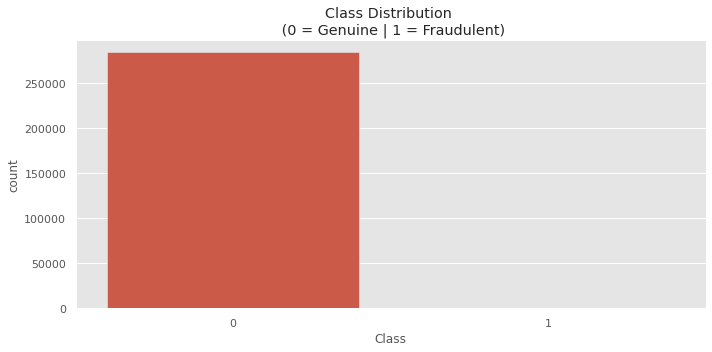

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Class', data = credit_card)
plt.title('Class Distribution \n (0 = Genuine | 1 = Fraudulent)');

In [25]:
# Balance of target variable
print(credit_card['Class'].value_counts(normalize = True)*100)

0    99.827251
1     0.172749
Name: Class, dtype: float64


We can see here that the data is heavily imbalanced, with 99.8% of the transactions being normal and only 0.17% of transactions being fraudulent. This will make our problem more difficult, as predictive models are likely to simply guess that transactions are genuine. In fact, if we randomly guess that a transaction is genuine, we will have an accuracy of 99.8%!

To counter this, we will consider undersampling and oversampling methods, which will allow us to work with the imbalanced data. Before we do so, however, we will continue to explore the dataset. 

### Separating the Test Data
Before we look at any of our data, we need to separate a test set for evaluation of our models. We want to do this before any preprocessing, as the preprocessing would be influenced by the test data, which is a form of data leakage. We will treat this project as if it was a real-world implementation of the task at hand: we will build a model with the data we have (training data), and we will use the model to make predictions on new credit card transactions (test data) as we receive them. 

Because the target variable is heavily skewed, we will stratify our splits to ensure the proper proportion of fraudulent and genuine transactions is included in our training and testing datasets. Since the data is currently ordered by `Time`, we will also shuffle the data.

In [26]:
train, test = train_test_split(credit_card, test_size = 0.2, shuffle=True, stratify=credit_card['Class'])
print("Train Shape: {} \nTest Shape: {}".format(train.shape, test.shape))

Train Shape: (227845, 31) 
Test Shape: (56962, 31)


In [27]:
# Checking target variable
print("Train: \n")
print(train['Class'].value_counts(normalize = True)*100, '\n')
print("Test: \n")
print(test['Class'].value_counts(normalize = True)*100, '\n')

Train: 

0    99.827075
1     0.172925
Name: Class, dtype: float64 

Test: 

0    99.827955
1     0.172045
Name: Class, dtype: float64 



We have now split our data and confirmed that the proper proportion of fraudulent transactions is represented in each dataset.

### Transaction Amount and Time
The amount and time variables are the only two features that have not been adjusted or scaled in the original dataset. Let us now explore these features.

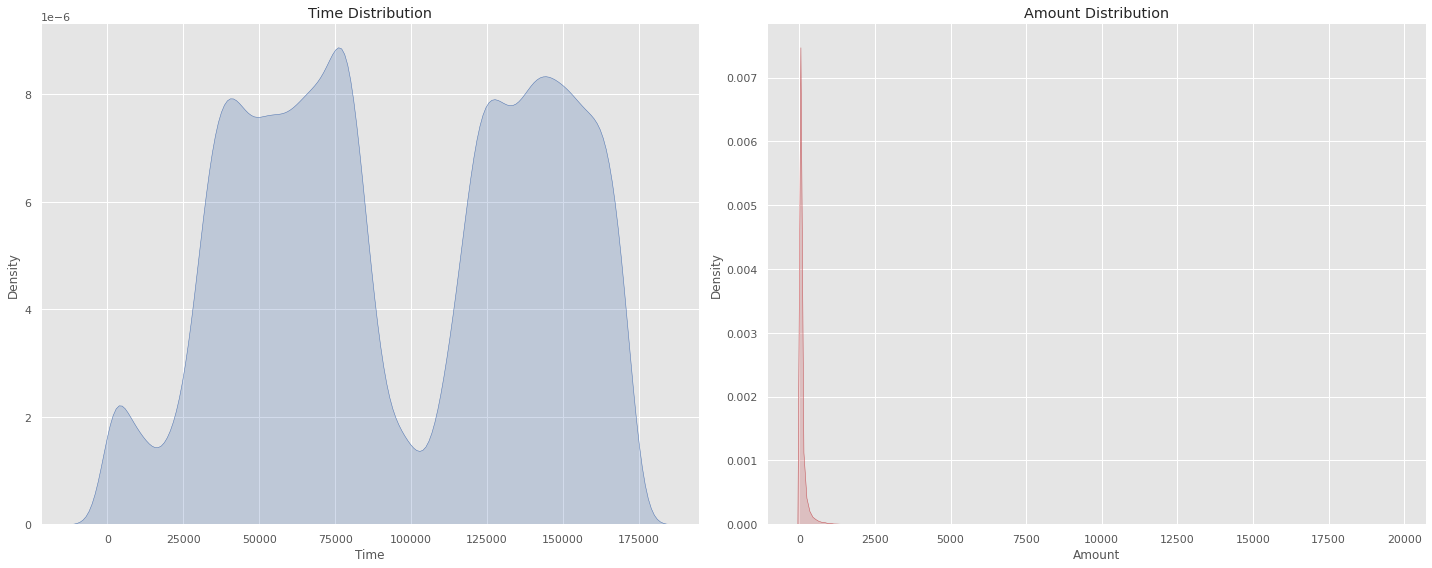

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

#Time
sns.kdeplot(ax=ax1, data=train, x='Time', color='b', fill=True)
ax1.set_title('Time Distribution')
# Amount
sns.kdeplot(ax=ax2, data=train, x='Amount', color='r', fill=True)
ax2.set_title('Amount Distribution');

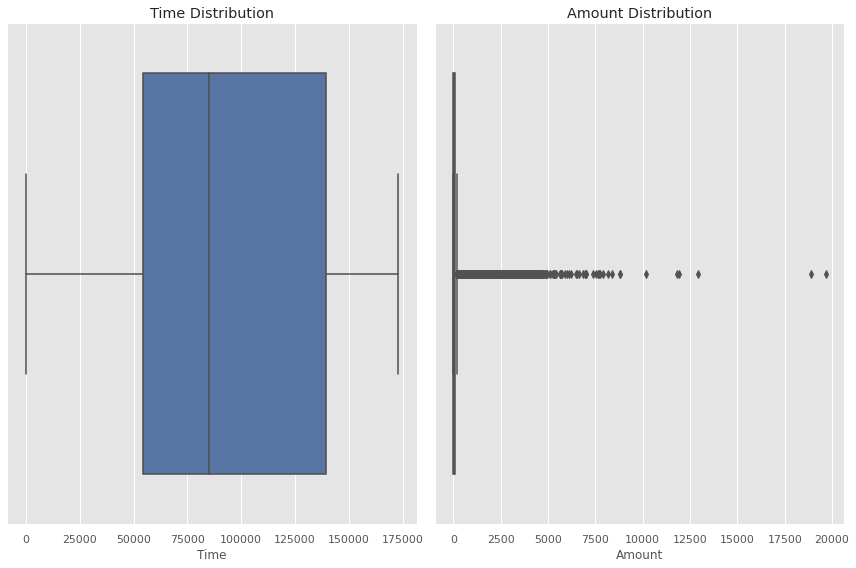

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2)

#Time
sns.boxplot(ax=ax1, data=train, x='Time', color='b')
ax1.set_title('Time Distribution')
# Amount
sns.boxplot(ax=ax2, data=train, x='Amount', color='r')
ax2.set_title('Amount Distribution');

Both of these features have interesting distributions. 

The `Amount` column is heavily right skewed, and we can see that although the average transaction amount is \$88, the maximum value is over $25,000! There are many outliers in this feature column, and we will consider scaling this feature in later steps.

We also see that time has an interesting distribution, but it has no outliers. Again, we will focus on scaling the features after we have dealt with the skewed target variable by oversampling/undersampling our dataset.

### Anonymized Features
Lastly, let's look at our 28 anonymized features. Although we cannot know exactly what these features mean due to the prior dimensionality reduction, we can see how they are distributed.

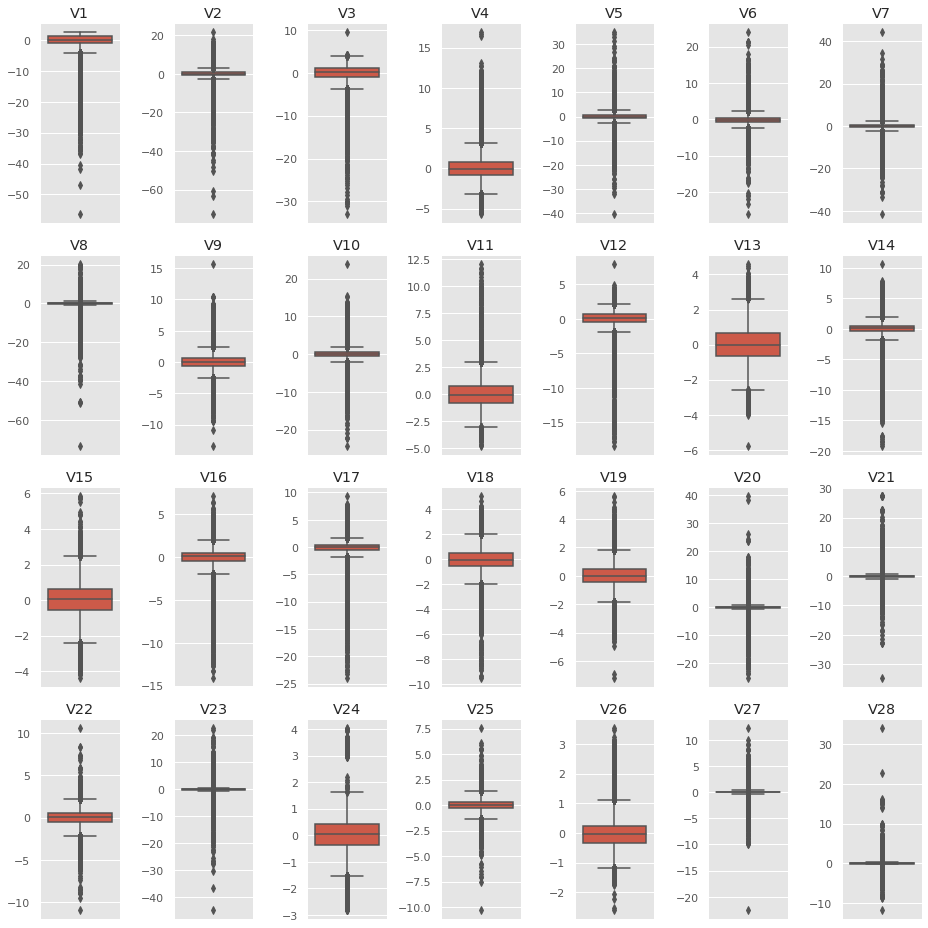

In [30]:
# Isolate anonymous features
anon_df = train.drop(['Time', 'Amount', 'Class'], axis=1)

# Create a grid containing boxplots of all features
fig, axs = plt.subplots(4,7, figsize = (13, 13))

for col in range(len(anon_df.columns)):
  column = anon_df.columns[col]
  plt.subplot(4, 7, col+1)
  sns.boxplot(data=anon_df[column])
  plt.title(str(column))
  plt.xticks([]) # Remove X ticks
plt.tight_layout();

As we can see, each of the features has a different distribution, and many have outliers. They all appear to be centered on 0, but the range of values differs across the features. 

## Data Preprocessing
Now that we have visualized our data, we will preprocess the data prior to developing our machine learning algorithms. 

### Missing Values

In [31]:
# Check for null values
train.isnull().values.any()

False

There are no missing values in our dataset, so there is no need for further action on this front.

### Feature Scaling
As we have seen, many of our features are skewed, and they have very diverse ranges of values. To correct for this, we will scale our data. 

While the anonymized features have already been reduced through PCA and thus undergone initial scaling prior to the PCA, we will scale them in this step. The reason for doing so is to bring all of our features to similar scales, even if they have been scaled before. Our chief concern in this regard is to ensure that our models are able to make predictions based on the information carried by our features, rather than by their ranges. 

In [32]:
X_train = train.drop('Class', axis=1)
y_train = train['Class']
X_test = test.drop('Class', axis=1)
y_test = test['Class']
print("X_train shape: {} \ny_train shape: {}\nX_test shape: {}\ny_test shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train shape: (227845, 30) 
y_train shape: (227845,)
X_test shape: (56962, 30)
y_test shape: (56962,)


We will use Scikit-learn's RobustScaler here since it is robust to outliers (using interquartile range rather than min-max). Note that we are fitting the scaler on only the training data, even when transforming the test data.

In [33]:
robust_scaler = RobustScaler()
X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

## Data Imbalance
As the target variable is heavily skewed, predictive models may be prone to assuming that test cases are genuine. However, we want our models to be able to accurately determine if new transactions are fraudulent given the input features. If we do not correct the data imbalance somehow, then our models will tend to overfit the genuine transaction data and are likely to be insensitive to fraudulent transactions.

We will consider a few approaches to correcting the imbalance:


### 1.   Undersampling


> Undersampling involves sampling a random subset of the data such that genuine and fraudulent transactions are represented. The main issue with this approach is that in our case, we would only have ~800 data points in total, since there are only about 400 fraudulent transactions. This would waste much of our data and result in models that are significantly less powerful than those given ample training data.


### 2.   Oversampling - SMOTE

>  Oversampling involves the artificial creation of new data points using the less frequently observed target variable. Synthetic Minority Oversampling Technique, or SMOTE, is amongst the most popular approaches to oversampling. SMOTE, developed by [Nitesth Chawla](https://arxiv.org/abs/1106.1813) is a data augmentation method that creates new minority class datapoints. SMOTE selects random minority class cases from the dataset and uses K Nearest Neighbors to find similar datapoints in the feature space. The method then creates a new example at the midpoint between the minority class example and its nearest neighbor. SMOTE has many advantages over the other methods, as it expands the dataset without discarding examples and also does so by adding new information, rather than simply duplicating the examples.

In this project, we will use SMOTE to artificially expand our dataset and to correct the data imbalance.

### Synthetic Minority Oversampling Technique (SMOTE)

Let's try out SMOTE to see if it is able to correct our data imbalance. SMOTE can be implemented through the `imblearn` Python library, which is built to be very similar to `sklearn`. 

In [34]:
smote_upsampler = SMOTE(sampling_strategy='minority', k_neighbors=5, n_jobs=-1)
X_train_upsample, y_train_upsample = smote_upsampler.fit_resample(X_train, y_train)
print('After upsampling: \nX_train shape: {} \ny_train shape: {}'.format(X_train_upsample.shape, y_train_upsample.shape))

After upsampling: 
X_train shape: (454902, 30) 
y_train shape: (454902,)


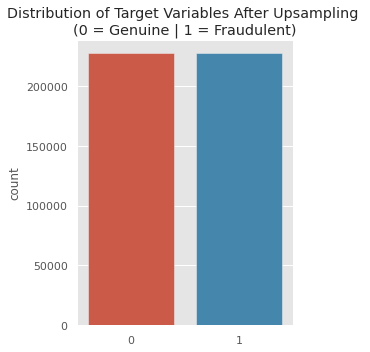

In [35]:
plt.figure(figsize=(5,5))
plt.title('Distribution of Target Variables After Upsampling \n(0 = Genuine | 1 = Fraudulent)')
sns.countplot(y_train_upsample);

We can now see that thanks to SMOTE, we have an equal number of fraudulent and genuine transactions. This will help us to create more powerful models.

#### Cross-Validation with SMOTE

Before we apply SMOTE to models, however, we have to understand how to use cross-validation to avoid overfitting. Because SMOTE creates new examples based on information in our dataset, we have to ensure that when splitting the data for cross-validation we do not allow training data to leak into the validation data. This would result in overfitting and throw off our model's performance.

Consider an example in which we have used SMOTE to create a new data point based on one of our fradulent card transactions. If the original transaction ends up in our training split and its augmented transaction ends up in the validation set, we have allowed information about the original transaction to leak into the validation set, since the new instance was generated from the original transaction.

To avoid this issue, we will be sure to split our data into folds prior to augmenting the data with SMOTE. 

Below, we create a function that will allow us to repeatedly use SMOTE with CV as we evaluate different models. 

In [36]:
def smote_cv(model, X, y, parms=None, cv=5, random_state=0):
  '''
  Given input data and model, this function will use SMOTE to 
  upsample the minority classes in the dataset and perform
  cross validation without data leakage 
  '''
  smote_cv = StratifiedKFold(n_splits=cv, shuffle=False, random_state=random_state)
  smote = SMOTE(sampling_strategy='minority', k_neighbors=5)

  # Ensure data is in dataframe
  X = pd.DataFrame(X)
  y = pd.DataFrame(y)

  precision_scores = []
  f1_scores = []
  recall_scores = []

  for train_index, valid_index in smote_cv.split(X, y):
    # Use indices to split data
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]

    # Apply SMOTE, but only to the training fold
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Fit model with new data
    model_smote = model.fit(
        X_train_smote, y_train_smote
    )
    
    # Make validation predictions
    y_pred = model_smote.predict(X_valid)

    #Score model using upsampled train data and original validation data
    f1 = f1_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred) 
    precision = precision_score(y_valid, y_pred) 

    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
  
  return {'f1': f1_scores, 'recall': recall_scores, 'precision': precision_scores}

Thanks to our function, we now have the capacity to apply SMOTE to our data and to safely implement cross validation. Let's try it out with a basic logistic regression model!

In [ ]:
%timeit
log_clf = LogisticRegression()
smote_cv(log_clf, X_train, y_train)

{'f1': [0.12141652613827993,
  0.1312741312741313,
  0.14081826831588964,
  0.11701308698999233,
  0.13345521023765997],
 'precision': [0.06498194945848375,
  0.07105538140020899,
  0.07613168724279835,
  0.06229508196721312,
  0.07192118226600985],
 'recall': [0.9230769230769231,
  0.8607594936708861,
  0.9367088607594937,
  0.9620253164556962,
  0.9240506329113924]}

While this function works and will allow us to apply SMOTE, there is an easier implementation that involves imbalanced-learn's pipelines, which work in a manner similar to scikit-learn's pipelines. The pipelines will allow us to fit SMOTE and models before performing cross-validation, preventing data leakage. 

**Note**: because the function names are identical to that of sklearn, it is important to be careful when importing, as this may overwrite existing sklearn pipeline functions. 

Below, we build a function that will create a pipeline and perform cross validation. This will make it easier for us to reproduce the process since all we expect to do is swap out the classifier.

We will also use this function to assess precision and recall, which we will explain in the next section.

In [37]:
def cv_pipeline(model, output_type = 'scores'):
  # Create the pipeline
  pipeline = make_pipeline(
      SMOTE(sampling_strategy='minority', k_neighbors = 5, random_state=0),
      model
      )

  # Cross validation with sklearn
  k_fold = StratifiedKFold(n_splits=5)
  scoring = {'f1': 'f1',
             'precision': 'precision',
             'recall': 'recall'}
  cv_scores = cross_validate(pipeline, X_train, y_train, scoring = scoring, cv = k_fold)
  
  # Average the recall and precision scores
  avg_precision = np.mean(cv_scores['test_precision'])
  avg_recall = np.mean(cv_scores['test_recall'])
  avg_f1 = np.mean(cv_scores['test_f1'])

  # Different output options

  if output_type == 'dict':
    output = {'precision': avg_precision,
              'recall': avg_recall,
              'f1': avg_f1}
    return output
  elif output_type == 'scores':
    return avg_f1, avg_precision, avg_recall
  elif output_type == 'print':
    print('Model: {} \nF1 score:{:.4f} \nPrecision: {:.4f} \nRecall: {:.4f}'.format(
        type(model).__name__, avg_f1, avg_precision, avg_recall
    ))

## Precision-Recall
Because we are working with imbalanced data that focuses on the minority class, we will be working with precision and recall as our measures of success. The schematic below helps to visualize precision and recall ([Source](https://medium.com/@alon.lek/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1)). Note that in our case, 'positive' actually refers to fraudulent transactions in this diagram.





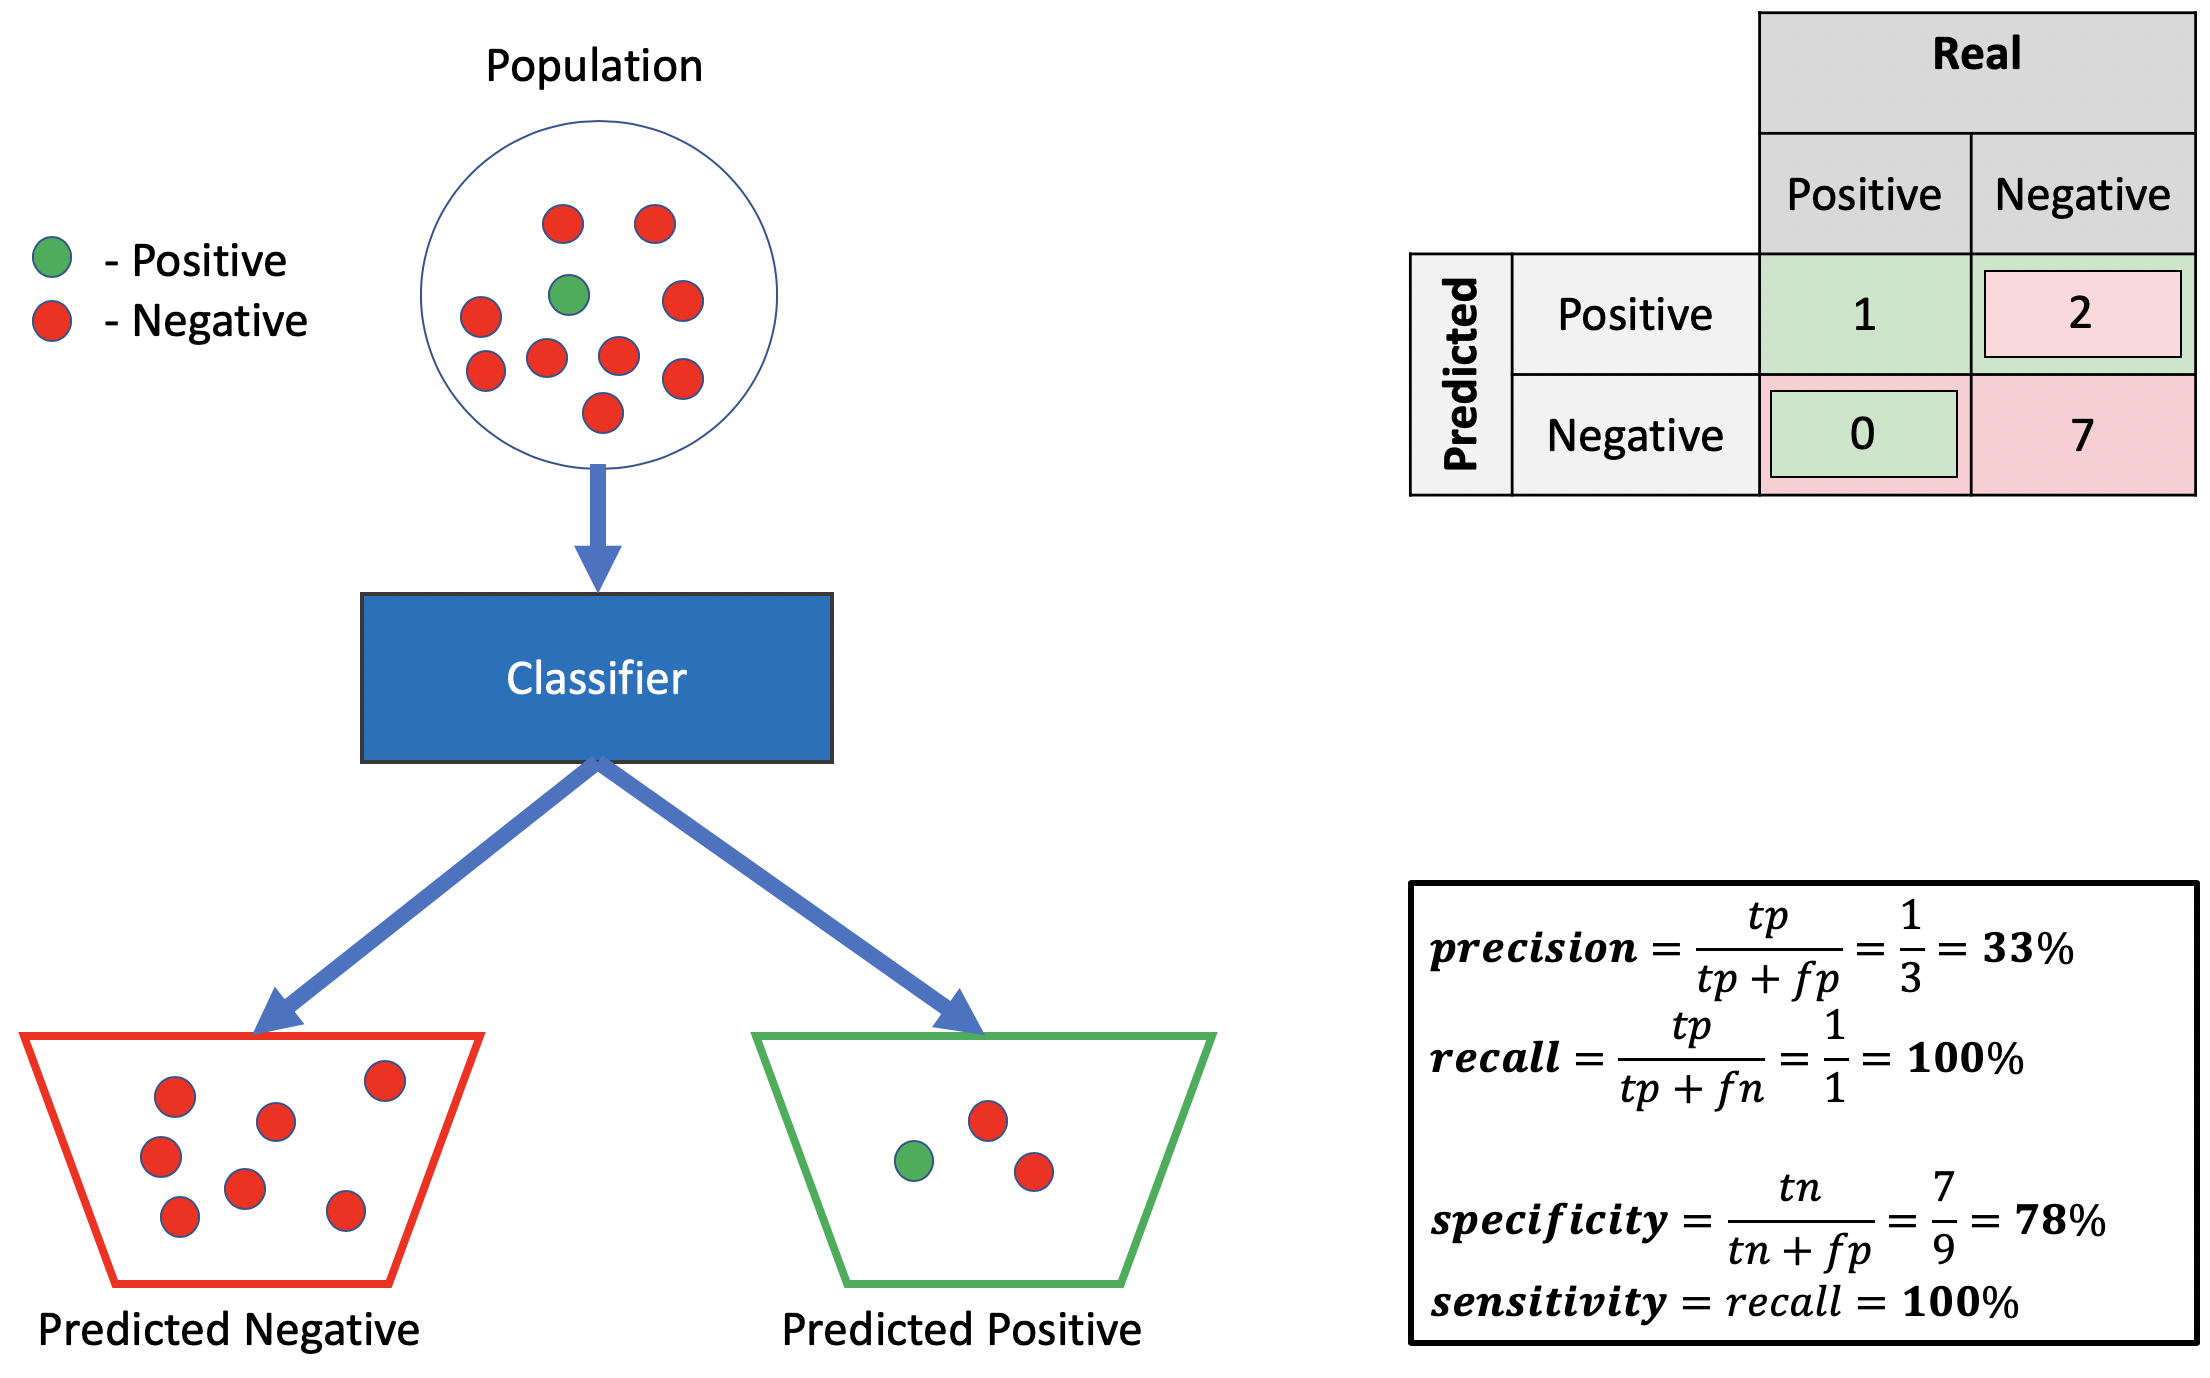

So what exactly are precision and recall, and why are they important here? Well, while we would typically use accuracy rates to assess our models when working with 2 classes that are equally present, accuracy is not very helpful in cases like ours, as choosing the more frequent class would give us over 99% accuracy every single time. 

Let's dive into precision and recall:

**1.   Precision**


> Precision is the rate of true positives out of all positive predictions. For example, if we classify 100 transactions as fraudulent and only 10 of them are truly fraudulent, then our precision would be 10%.

> Having a high precision is crucial because it means that we can be confident that our model is detecting fraudulent activity, and that we are not marking genuine transactions as fraudulent.


**2.   Recall**



> Recall is the rate of true positives out of all transactions that are positive. In our case, this refers to the rate at which we are able to identify fraudulent transactions as fraudulent. For example, if we have 100 fraudulent transactions and only identified 50% of them as fraudulent, our recall would be 50%. 

> High recall is also crucial because it means that we are catching all of the fraudulent transactions.

**3. F1 Score**
> We want to achieve a high precision and recall, but there is a tradeoff. As precision goes up, recall goes down, since models tuned to prioritize recall will not perform as well with regards to precision, and vice versa. As we consider the tradeoff, we can use the F1 score as a metric, which is the harmonic mean of precision and recall. This acts as sort of a proxy for overall accuracy, and is sensitive to extreme numbers (i.e. if either recall or precision is poor, F1 will be poor as well). 







Now that we know why precision and recall are important, let's test our function out. 

In [ ]:
%%time
cv_pipeline(log_clf, output_type='print')

Model: LogisticRegression 
F1 score:0.1284 
Precision: 0.0691 
Recall: 0.9239
CPU times: user 52.9 s, sys: 18 s, total: 1min 10s
Wall time: 38.5 s


Our function works, and it will make it very easy for us to repeat this process! As we can see, the model has high recall but very poor precision. This means that this model is falsely classifying transactions as fraudulent. However, we are not concerned, as this model is simply an initialization of logistic regression, with no customization at all. 

## Building Base Classifiers
Now that we have tackled the data imbalance, we can begin the process of building predictive models. To start, let's select a few classifiers, initialize them with basic parameters, and compare their performances! 

We will not use an exhaustive list of classifiers here, but will include a few standard classifiers (such as logistic regression) and some cutting-edge classifiers (XGBoost and LightGBM). 

In [ ]:
models = [
          # Linear models
          LogisticRegression(),

          # Ensemble methods
          RandomForestClassifier(max_depth=5, n_jobs=-1),
          XGBClassifier(max_depth=3, booster='gbtree'),
          LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1)
]

In [ ]:
# Looping through each model and storing results in lists
base_model_name = []
base_model_f1 = []
base_model_precision = []
base_model_recall = []
base_model_time = []

In [ ]:
for model in models:
  start = time.time()
  results = cv_pipeline(model, output_type='dict')

  base_model_name.append(type(model).__name__)
  base_model_f1.append(results['f1'])
  base_model_precision.append(results['precision'])
  base_model_recall.append(results['recall'])
  base_model_time.append(time.time()-start)
  print(type(model).__name__, 'time: {}'.format(time.time()-start))

LogisticRegression time: 38.60160493850708
RandomForestClassifier time: 366.5235779285431
XGBClassifier time: 411.6011824607849
LGBMClassifier time: 42.96838450431824


In [ ]:
base_models = pd.DataFrame(data=[base_model_name,
                   base_model_f1,
                   base_model_precision,
                   base_model_recall,
                   base_model_time]).T
base_models.columns = ['Model','f1_score',
                       'precision', 'recall', 'time']
base_models.sort_values('f1_score', ascending=False)

,Model,f1_score,precision,recall,time
3,LGBMClassifier,0.725937,0.634738,0.85297,42.9684
1,RandomForestClassifier,0.383901,0.24643,0.885881,366.524
2,XGBClassifier,0.249842,0.145542,0.890944,411.601
0,LogisticRegression,0.121563,0.0651861,0.908698,38.6016


Our base models had varying levels of performance with no parameters set. 

The Light GBM classifier performed very well with default parameters, and did so with only a fraction of the time that it took Random Forest. Considering the algorithm's speed, we will focus on this algorithm moving forest. Random Forest has the advantage of being a very accurate model that is relatively easy to tune, especially when allowed to grow trees without a max_depth set, but it takes much longer to achieve this accuracy. Light GBM is more challenging to tune and implement, but it appears to be the most promising model.

Moving forward, we will explore the XGBoost and LightGBM algorithms. These algorithms have been proven as highly accurate and efficient. Although our XGBoost model did not perform very well out of the box, I suspect that it will perform very well with a little bit of parameter tuning. Additionally, the XGBoost library offers out of the box GPU support, and thus it will be easy for us to tune the algorithm, so there is limited downside to exploring the model further.

## Exploring Light GBM

Light GBM offers three different implementations of gradient boosted ensemble methods. In our previous assessment, we used the gradient boosted decision trees (gbdt) method, which is the default. GBDT works by training a large number of weak decision trees. The algorithm first trains decision trees to fit the target variable, then trains subsequent decision trees on the residuals of the first tree (i.e. the difference between predicted target and actual target). 

GBDT, however, takes a while to find the best splits for the decision trees and is prone to overfitting. That's where the Goss method comes in: rather than training subsequent trees on all residuals, the Goss method only trains on the large residuals. This reduces the information needed for fitting each iteration and often results in faster fit times--thus "Light" GBM. 

Because LGBM is prone to overfitting, we will plot the learning curves for the base model to discover how we can improve performance. Learning curves display model performance and fit times as a function of training size. Here, we will use the `sklearn` implementation introduced in our utility function section to analyze performance. 

In [38]:
# Setting up k-fold cross validation
k_fold = StratifiedKFold(n_splits=5)

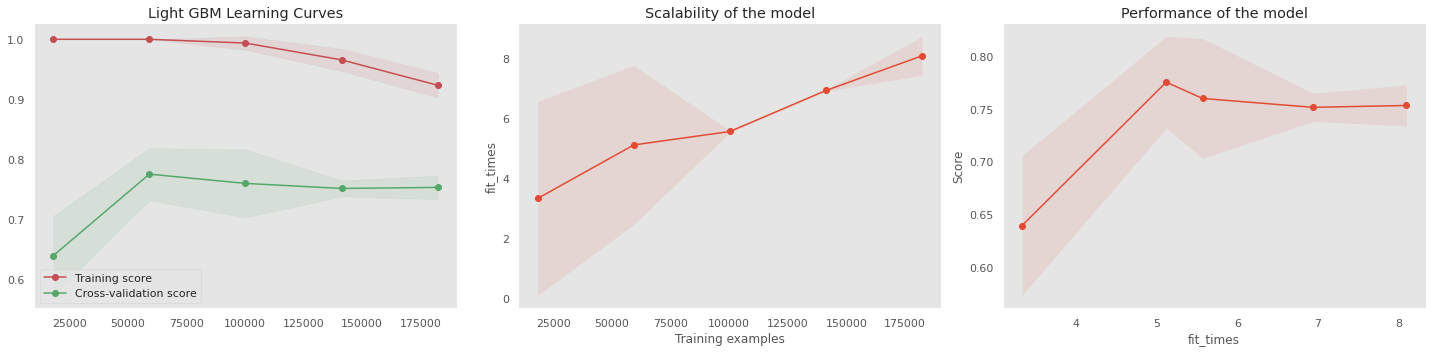

In [ ]:
lgb_clf = LGBMClassifier(device_type = 'gpu', objective='binary')

lgb_pipeline = Pipeline([
                         ('sampling', SMOTE(sampling_strategy='minority', k_neighbors = 5, random_state=0)),
                         ('clf', lgb_clf)
])

plot_learning_curve(lgb_pipeline, 'Light GBM Learning Curves', X_train, y_train, cv=k_fold);

These curves show us that as we increase the number of training examples, both training and validation performance decrease. This means that our model is overfitting. To combat overfitting, we will tune a few of our model parameters to weaken individual decision trees through regularization. While hyperparameter optimization would normally be a good option, it would take very long in this case, so we will tune our parameters manually and save hyperparameter optimization for the XGBoost model. 

**Note:** This is an iterative process, through which we tested different parameter values and used the learning curves to guide our tuning. The learning curves help to visualize whether the model is over or underfitting, helping us to decide on which parameters to tune and what values to try. 

In [39]:
k_fold = StratifiedKFold(n_splits=5)
lgb_clf = LGBMClassifier(
    # GPU Parameters
    device = 'gpu', gpu_platform_id = 0, gpu_device_id = 0,
    # Max bin = 63 recommended for GPU
    max_bin = 63, gpu_use_dp = False, tree_learner = 'serial',
    # More operational parameters
    n_jobs = -1, force_col_wise= True, verbose=0, 
    # Model parameters
    n_estimators = 100, 
    num_leaves = 255, learning_rate = 0.1,
    subsample = 0.7,
    )
lgb_pipeline = Pipeline([
                         ('sampling', SMOTE(sampling_strategy='minority', k_neighbors = 5, random_state=0)),
                         ('clf', lgb_clf)
])

Time: 145.55


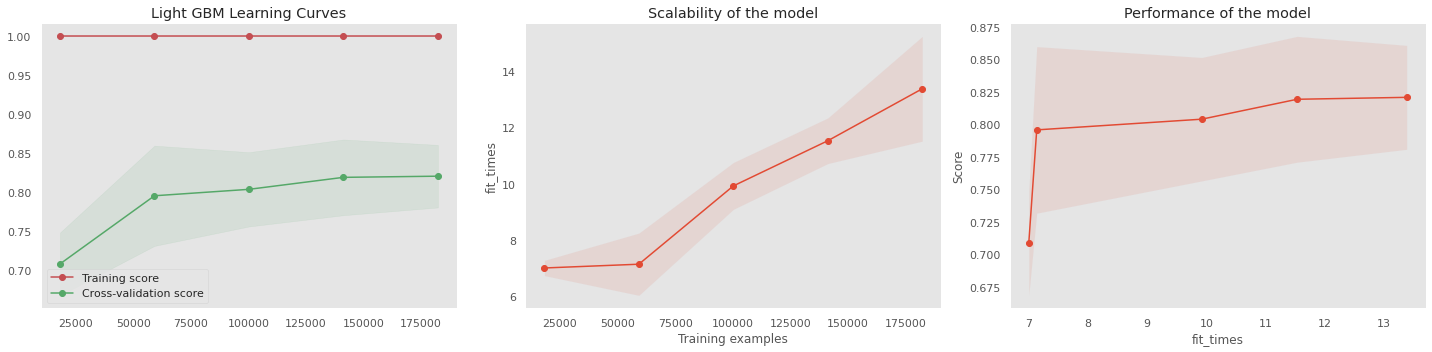

In [ ]:
start = time.time()

plot_learning_curve(lgb_pipeline, 'Light GBM Learning Curves', X_train, y_train, cv=k_fold);
print('Time: {:.2f}'.format(time.time()-start))

In [ ]:
start = time.time()
cv_pipeline(lgb_pipeline, output_type='print')
print('Time: {:.2f}'.format(time.time()-start))

Model: Pipeline 
F1 score:0.8296 
Precision: 0.8327 
Recall: 0.8275
Time: 38.20


This is much better. We were able to maintain training accuracy while increasing cross-validation accuracy, so we are on the right path. Additionally, it looks like our model achieves high recall and high precision, which explains the high F1 score. We will continue to tune our model.

### Randomized Search (Sample Code)
Below is the code for tuning LGBM hyperparameters using Randomized Search. Running only 50 iterations of this took a couple of hours and did not yield favorable results, so we will not focus on this. However, the code has been maintained for reference. 

We will tune our LGBM hyperparameters using Randomized Search. We will provide probability distributions for each parameter, depending on our expectations of where the ideal hyperparameter values will lie, then allow the sklearn implementation of RandomizedSearchCV to randomly search through the distributions for a set number of iterations. 

For LGBM we will use 2,000 iterations of Random Search. To do this, we will define the parameter space, create the pipeline, then call the Random Search. With this, we will search 2,000 different combinations of hyperparameters to find the most optimal set for our model.

Note that because we are using pipelines, parameter names must be preceded by the step in the pipeline for which they are intended. In this case, our classifier is labeled 'clf' in the pipeline, so parameter names are preceded by *clf__* (2 underscores).

In [ ]:
lgb_params = [{
            'clf__learning_rate': stats.loguniform(0.01, 1),
            'clf__n_estimators': stats.randint(100, 500),
            'clf__reg_alpha': stats.loguniform(0.01, 1),
            'clf__num_leaves': stats.randint(1, 50),
            'clf__bagging_fraction': stats.uniform(0, 1),
            'clf__reg_lambda': stats.uniform(0,1),
}]
scoring = {'f1': 'f1',
          'precision': 'precision',
          'recall': 'recall'}

k_fold = StratifiedKFold(n_splits=5)
lgb_clf = LGBMClassifier(
    # GPU Parameters
    device = 'gpu', gpu_platform_id = 0, gpu_device_id = 0,
    # Max bin = 63 recommended for GPU
    max_bin = 63, gpu_use_dp = False, tree_learner = 'serial',
    # More operational parameters
    n_jobs = -1, force_col_wise= True, verbose=-1, 
    )

lgb_pipeline = Pipeline([
                         ('sampling', SMOTE(sampling_strategy='minority', k_neighbors = 5, random_state=0)),
                         ('clf', lgb_clf)
])

lgb_search = RandomizedSearchCV(lgb_pipeline, param_distributions=lgb_params, n_iter=50, scoring=scoring, cv=k_fold, refit='f1')

lgb_search.fit(X_train, y_train)
lgb_clf = lgb_search.best_estimator_
lgb_params = lgb_search.best_params_
print('Best Light GBM f1 score: {:.4f}'.format(lgb_search.best_score_))
print('Best parameters: {}'.format(lgb_params))

In [ ]:
print('Best Light GBM f1 score: {:.4f}'.format(lgb_search.best_score_))

Best Light GBM f1 score: 0.8066


In [ ]:
print('Best parameters: {}'.format(lgb_params))

Best parameters: {'clf__bagging_fraction': 0.6591315214848038, 'clf__learning_rate': 0.14995078886510665, 'clf__max_depth': 6, 'clf__n_estimators': 428, 'clf__num_leaves': 25, 'clf__reg_alpha': 0.28628192918629314, 'clf__reg_lambda': 0.19654741754596328}


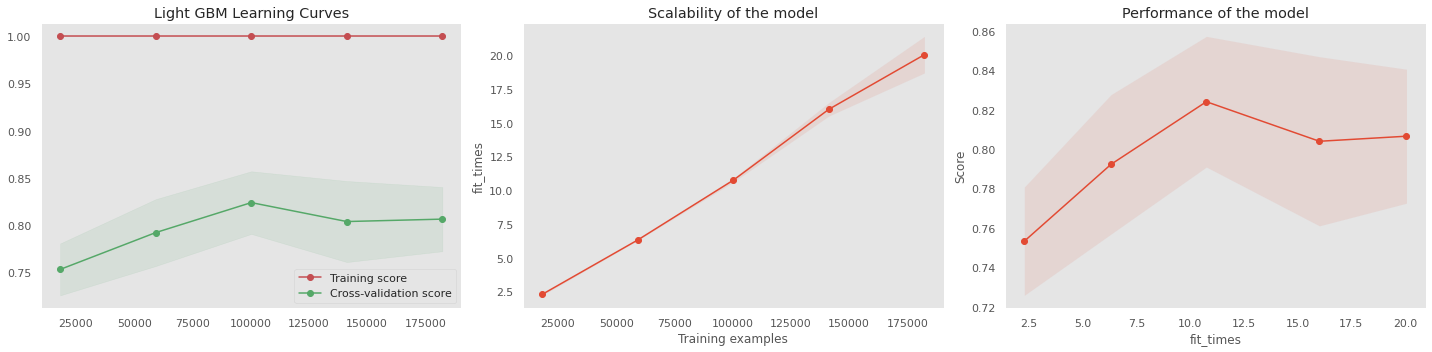

In [ ]:
lgb_clf = lgb_search.best_estimator_
lgb_pipeline = Pipeline([
                         ('sampling', SMOTE(sampling_strategy='minority', k_neighbors = 5, random_state=0)),
                         ('clf', lgb_clf)
])

plot_learning_curve(lgb_pipeline, 'Light GBM Learning Curves', X_train, y_train, cv=k_fold);

In [ ]:
start = time.time()
cv_pipeline(lgb_pipeline, output_type='print')
print('Time: {:.2f}'.format(time.time()-start))

[LightGBM] [Warning] bagging_fraction is set=0.6591315214848038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6591315214848038
[LightGBM] [Warning] bagging_fraction is set=0.6591315214848038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6591315214848038
[LightGBM] [Warning] bagging_fraction is set=0.6591315214848038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6591315214848038
[LightGBM] [Warning] bagging_fraction is set=0.6591315214848038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6591315214848038
Model: Pipeline 
F1 score:0.8066 
Precision: 0.7967 
Recall: 0.8174
Time: 63.51


Unfortunately we need many more iterations in order to improve performance. We will try this with XGBoost since the algorithm will run much faster. 

## Exploring XGBoost 

Let's evaluate XGBoost out of the box again, but this time with GPU enabled. 

In [ ]:
k_fold = StratifiedKFold(n_splits=5)

xgb_clf = XGBClassifier(tree_method='gpu_hist')

start = time.time()
xgb_pipeline = Pipeline([
                         ('sampling', SMOTE(sampling_strategy='minority', k_neighbors = 5, random_state=0)),
                         ('clf', xgb_clf)
])

cv_pipeline(xgb_pipeline, output_type='print')
print('Time: {:.2f}'.format(time.time()-start))

Model: Pipeline 
F1 score:0.2599 
Precision: 0.1529 
Recall: 0.8935
Time: 7.57


Even with 5 fold cross validation using SMOTE, the entire operation on GPU took about 8 seconds! As with Light GBM, the GPU support will make our computations run much faster, which will allow us to run more iterations of search in the same amount of time. 

#### Randomized Search 

In [ ]:
param_grid = [{
            'clf__learning_rate': stats.loguniform(0.01, 1),
            'clf__max_depth': stats.randint(1, 5),
            'clf__n_estimators': stats.randint(100, 500),
            'clf__reg_alpha': stats.loguniform(0.01, 1),
            'clf__min_child_weight': stats.randint(1, 100),
            'clf__gamma': stats.randint(1, 100),
            'clf__col_samply_by_tree': stats.uniform(0.5, 1.0)
}]
scoring = {'f1': 'f1',
          'precision': 'precision',
          'recall': 'recall'}

k_fold = StratifiedKFold(n_splits=5)

xgb_pipeline = Pipeline([
                         ('sampling', SMOTE(sampling_strategy='minority', k_neighbors = 5, random_state=0)),
                         ('clf', XGBClassifier(tree_method = 'gpu_hist', early_stopping_rounds = 20))
])

xgb_search = RandomizedSearchCV(xgb_pipeline, param_distributions=param_grid, n_iter=1000, scoring='f1', cv=k_fold, refit='f1')

xgb_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('sampling',
                                              SMOTE(k_neighbors=5,
                                                    kind='deprecated',
                                                    m_neighbors='deprecated',
                                                    n_jobs=1,
                                                    out_step='deprecated',
                                                    random_state=0, ratio=None,
                                                    sampling_strategy='minority',
                                                    svm_estimator='deprecated')),
                                             ('clf',
                                              XGBClassifier(bas...
                                         'clf__min_ch

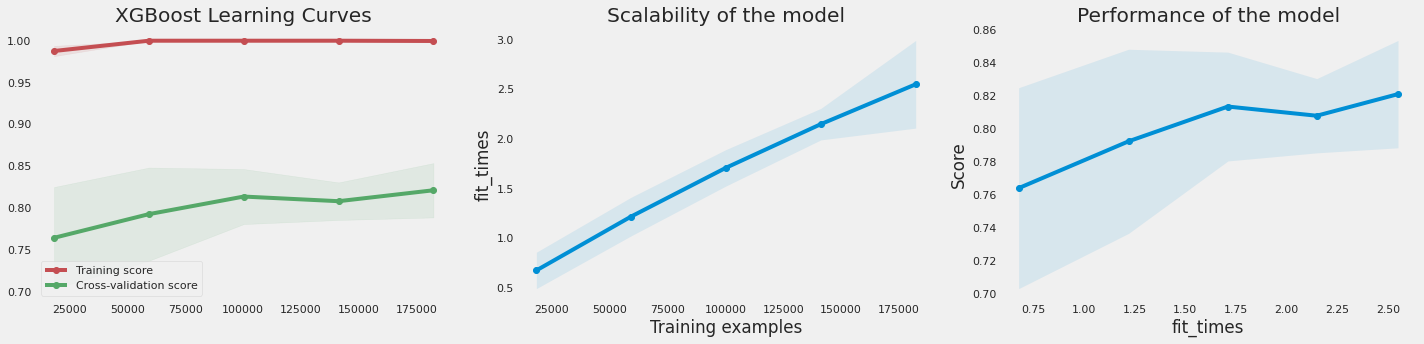

In [ ]:
xgb_clf = xgb_search.best_estimator_
xgb_pipeline = Pipeline([
                         ('sampling', SMOTE(sampling_strategy='minority', k_neighbors = 5, random_state=0)),
                         ('clf', xgb_clf)
])

plot_learning_curve(xgb_pipeline, 'XGBoost Learning Curves', X_train, y_train, cv=k_fold);

In [ ]:
start = time.time()
cv_pipeline(xgb_pipeline, output_type='print')
print('Time: {:.2f}'.format(time.time()-start))

Model: Pipeline 
F1 score:0.8211 
Precision: 0.7955 
Recall: 0.8503
Time: 7.98


In [ ]:
xgb_clf = xgb_search.best_estimator_
xgb_params = xgb_search.best_params_

In [ ]:
xgb_clf

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=0, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               col_samply_by_tree=1.3524460165118497,
                               colsample_bylevel=1, colsample_bynode=1,
                               co...topping_rounds=20,
                               gamma=73, learning_rate=0.5318304572904284,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=None,
                               n_estimators=139, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                

In [ ]:
xgb_params

{'clf__col_samply_by_tree': 1.3524460165118497,
 'clf__gamma': 73,
 'clf__learning_rate': 0.5318304572904284,
 'clf__max_depth': 4,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 139,
 'clf__reg_alpha': 0.7561010481304831}

With 1,000 iterations of XGBoost, it appears that this model had a similar performance to LGBM. 

## Evaluating Models on the Test Set
In this last section, we will evaluate the various models on the test set. We will fit the tuned XGBoost and LightGBM models to the upsampled data, then use these models to predict on the test set, which has not been upsampled. 

Additionally, we will also train an Artificial Neural Network (ANN) for classification. Deep Learning models have been proven to be very effective for classification problems, and we will assess whether they are able to perform as well as our GBM models. 

We have reserved ANNs for this last step because we used SMOTE, and it would be very difficult to perform cross validation using ANNs in the way that we have with scikit-learn models. This is something that I may choose to explore in future projects. 

We will create one simple ANN architecture and create 2 models: the first model will be trained on the upsampled data, and the second model will be trained on the original data. We will then test these models and the gradient boosting models on the test data to see how they compare in terms of performance. This will allow us to compare neural networks and gradient boosting machines, but also show us exactly how impactful (if at all) SMOTE upsampling is for our classification problem. 

### Artificial Neural Networks

Lastly, we will explore the application of neural networks to our problem. We will build a simple neural with an input layer, two hidden layers, and one output layer. We will use Leaky Rectified Linear Unit as our activation function, as it has been shown to perform as well as, if not better than, traditional ReLU, which is the most common activation function.

#### Training on Imbalanced Data

In [43]:
# Model parameter variables for easy adjusting
kernel_initializer = 'glorot_uniform'
optimizer = 'adam'
batch_size = 128
callbacks = [ReduceLROnPlateau(patience=5, factor=0.1)]

In [ ]:
model = Sequential()
# Input layer
model.add(Dense(128, kernel_initializer=kernel_initializer))
model.add(LeakyReLU())
model.add(Dropout(0.3))

# Hidden layer 
model.add(Dense(128, kernel_initializer=kernel_initializer))
model.add(LeakyReLU())
model.add(Dropout(0.3))

# Hidden layer 
model.add(Dense(128, kernel_initializer=kernel_initializer))
model.add(LeakyReLU())
model.add(Dropout(0.3))

# Output layer/classifier 
model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

# Compile the model
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(
    X_train, y_train, 
    validation_data = (X_test, y_test), 
    epochs = 30, shuffle = False, batch_size = batch_size,
    callbacks = [callbacks]
)

Epoch 1/30
1781/1781 [==============================] - 6s 3ms/step - loss: 0.0262 - accuracy: 0.9946 - val_loss: 0.0064 - val_accuracy: 0.9992
Epoch 2/30
1781/1781 [==============================] - 5s 3ms/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.0058 - val_accuracy: 0.9992
Epoch 3/30
1781/1781 [==============================] - 6s 3ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0049 - val_accuracy: 0.9992
Epoch 4/30
1781/1781 [==============================] - 5s 3ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.0051 - val_accuracy: 0.9992
Epoch 5/30
1781/1781 [==============================] - 6s 3ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0050 - val_accuracy: 0.9993
Epoch 6/30
1781/1781 [==============================] - 6s 3ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0049 - val_accuracy: 0.9993
Epoch 7/30
1781/1781 [==============================] - 5s 3ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0050 - val_accuracy:

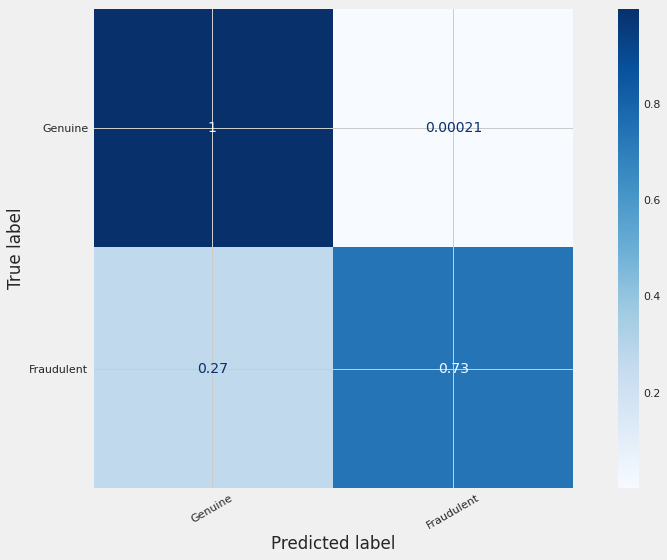

In [ ]:
y_pred = model.predict_classes(X_test, batch_size=batch_size)
plot_confusion(y_test, y_pred)

Our neural network trained on the original imbalanced data had very high True Negative Rate, correctly classifying virtually 100% of genuine transactions as genuine. However, this model also had a high False Negative Rate, incorrectly classifying 27% of fraudulent transactions as genuine. 

This is very concerning, as it means that this model would miss nearly a third of fraudulent transactions. In this case, we would prefer a model that errs on the side of classifying transactions as fraud. However, since the data was heavily imbalanced, this is exactly what we expected. Let's see then, if the neural network trained on the upsampled data performs any better. 

#### Training on SMOTE Upsampled Data

In [ ]:
smote_upsample = SMOTE(sampling_strategy='minority', k_neighbors=5)
X_train_smote, y_train_smote = smote_upsample.fit_resample(X_train, y_train)
print(X_train_smote.shape, y_train_smote.shape)

(454902, 30) (454902,)


In [ ]:
# Model parameter variables for easy adjusting
kernel_initializer = 'glorot_uniform'
optimizer = 'adam'
batch_size = 128
callbacks = [ReduceLROnPlateau(patience=5, factor=0.1)]

In [ ]:
model = Sequential()
# Input layer
model.add(Dense(128, kernel_initializer=kernel_initializer))
model.add(LeakyReLU())
model.add(Dropout(0.3))

# Hidden layer 
model.add(Dense(128, kernel_initializer=kernel_initializer))
model.add(LeakyReLU())
model.add(Dropout(0.3))

# Hidden layer 
model.add(Dense(128, kernel_initializer=kernel_initializer))
model.add(LeakyReLU())
model.add(Dropout(0.3))

# Output layer/classifier 
model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

# Compile the model
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(
    X_train_upsample, y_train_upsample, 
    validation_data = (X_test, y_test), 
    epochs = 30, shuffle = False, batch_size = batch_size,
    callbacks = [callbacks]
)

Epoch 1/30
3554/3554 [==============================] - 11s 3ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 4.0637 - val_accuracy: 0.4275
Epoch 2/30
3554/3554 [==============================] - 11s 3ms/step - loss: 0.0076 - accuracy: 0.9986 - val_loss: 9.9683 - val_accuracy: 0.0019
Epoch 3/30
3554/3554 [==============================] - 11s 3ms/step - loss: 0.0130 - accuracy: 0.9982 - val_loss: 13.1939 - val_accuracy: 0.0098
Epoch 4/30
3554/3554 [==============================] - 11s 3ms/step - loss: 0.0157 - accuracy: 0.9980 - val_loss: 10.8907 - val_accuracy: 0.0405
Epoch 5/30
3554/3554 [==============================] - 11s 3ms/step - loss: 0.0141 - accuracy: 0.9982 - val_loss: 4.4154 - val_accuracy: 0.3970
Epoch 6/30
3554/3554 [==============================] - 11s 3ms/step - loss: 0.0088 - accuracy: 0.9985 - val_loss: 3.8439 - val_accuracy: 0.5663
Epoch 7/30
3554/3554 [==============================] - 11s 3ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 5.2339 - val_

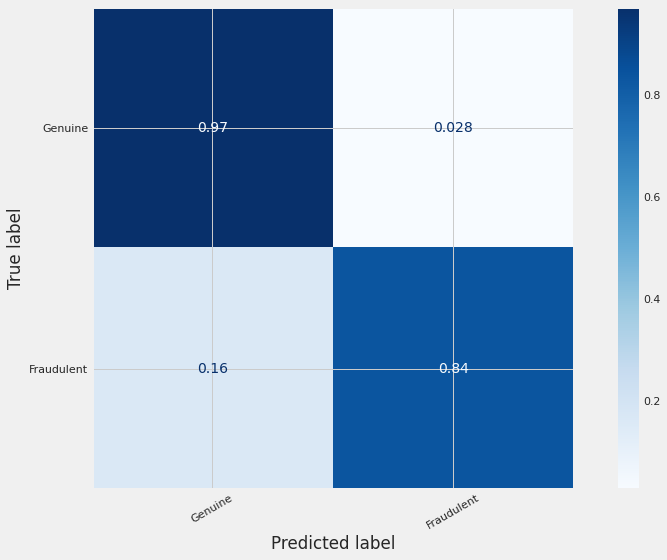

In [ ]:
y_pred = model.predict_classes(X_test, batch_size=batch_size)
plot_confusion(y_test, y_pred)

Fortunately, we see that our neural network trained on the SMOTE upsampled data had a very high True Negative Rate and a lower False Negative Rate. This model will miss 16% of fraudulent transactions, which is not perfect--however, it is much better than the previous model. It will also incorrectly classify 3% of genuine transactions as fraud, but we are less concerned about that, as we want to ensure that we catch as much fraud as possible. 

### Gradient Boosting Models
Now, let's evaluate our XGB and LGBM models on the test data and view the confusion matrices. To do so, we will train both models on the upsampled data then test on the original test set. 

#### Light GBM
Using our manually tuned LGBM model, we will predict on the test set. 

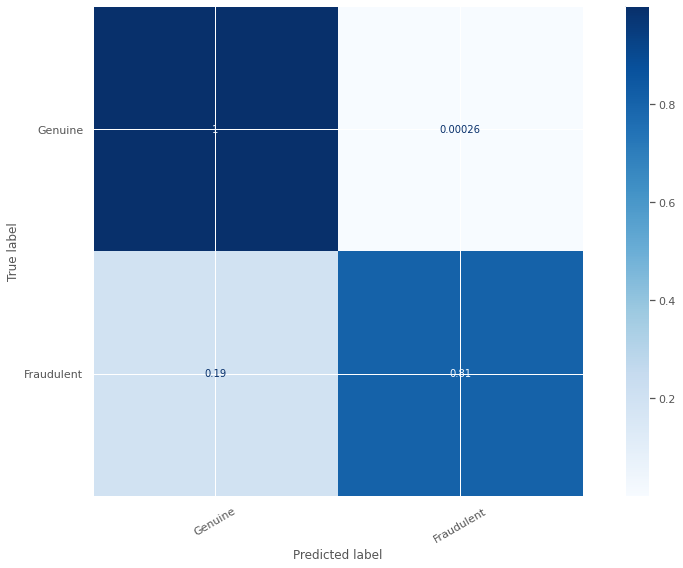

In [49]:
model = LGBMClassifier(
    tree_learner = 'serial',
    # More operational parameters
    n_jobs = -1, force_col_wise= True, verbose=0, 
    # Model parameters
    n_estimators = 100, 
    num_leaves = 255, learning_rate = 0.1,
    subsample = 0.7,
    )
model.fit(X_train_upsample, y_train_upsample)
y_pred = model.predict(X_test)
plot_confusion(y_test, y_pred)

The results of the confusion matrix show that the Light GBM model did not perform as well as the SMOTE neural network in terms of minimizing the False Negative Rate. However, it still performed better than the neural network trained on the imbalanced data. 

#### XGBoost
We will rebuild the XGBoost model using the parameters determined through our Randomized Search. 

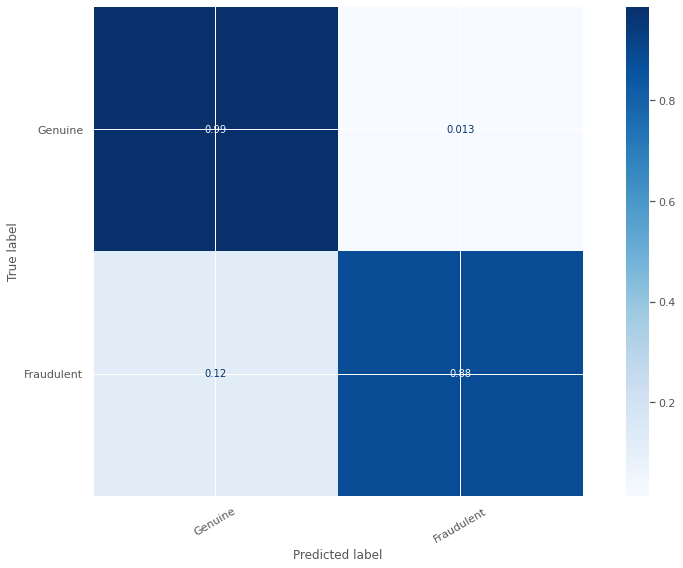

In [46]:
xgb_params = {
    'tree_method' : 'gpu_hist',
    'clf__col_samply_by_tree': 1.3524460165118497,
    'clf__gamma': 73,
    'clf__learning_rate': 0.5318304572904284,
    'clf__max_depth': 4,
    'clf__min_child_weight': 1,
    'clf__n_estimators': 139,
    'clf__reg_alpha': 0.7561010481304831
              }

model = XGBClassifier(**xgb_params)
model.fit(X_train_upsample, y_train_upsample)
y_pred = model.predict(X_test)
plot_confusion(y_test, y_pred)

Our last model, XGBoost, had a False Negative Rate of 12%, which was the lowest of the four models we evaluated. Interestingly, the model achieved this lowest False Negative Rate while maintaining a True Negative Rate of 99%, which is very good. This model, therefore, appears to be the most effective, as it finds an excellent balance between precision and recall. 

## Discussion
In this project, we evaluated a variety of models on a heavily imbalanced dataset of credit card transactions. The imbalanced data makes it difficult for machine learning models to accurately detect the minority class (in our case, fraudulent transactions), as the models have a tendency to predict the majority class (this is because, in nearly all cases, guessing the majority class will indeed be correct). 

Oversampling involves the artificial creation of new data points using the less frequently observed target variable.

To counter data imbalance, we upsampled our data with a method known as   Synthetic Minority Oversampling Technique, or SMOTE. SMOTE is a data augmentation technique that generates new examples of the minority class using K Nearest Neighbors, artificially increasing the size of the minority class so that it is equal to the size of the majority class. We found that SMOTE helped our models perform better when classifying transactions as fraud, since the models had more data in this class.  

When evaluating our models on the test set, we found that our XGBoost model tuned with Randomized Search had the best performance. This model was able to correctly classify 88% of fraudulent transactions as fraud and correctly classify 99% of genuine transactions as genuine. The model had a high precision and recall, even when compared to the other models we evaluated. 

In conclusion, we found that the XGBoost model performed best, but that all models trained on the SMOTE data had similar performance. SMOTE is a very useful and powerful technique for working with imbalanced datasets. 